In [1]:
import numpy as np
import pandas as pd

from scipy.ndimage import uniform_filter1d
from scipy.optimize import curve_fit
from scipy import integrate

import matplotlib.pyplot as plt

In [2]:
def conv_energy(x):
    energy=0.000002*x**2 - 0.0003 * x + .1265
    return energy

In [3]:
def rmv_mean(df_camera,lastpoints):
    x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
    #get the coeficients for each shhot
    coef=df_camera.apply(lambda row: np.polyfit(x[-lastpoints:], row[-lastpoints:], 1),axis=1, result_type='expand').to_numpy()
    m=coef[:,0]
    b=coef[:,1]

    #build the aray with the fitting for every shot
    fit=[]
    for i in range(0,len(m)):
        fit.append(m[i]*x+b[i])
    df_fitting=pd.DataFrame(fit)

    #df_adjusted=df_camera-df_fitting
    return df_camera-df_fitting

In [4]:
filename_cam='datasets/galadriel_dataset_24_08_28_cam.npy'

In [5]:
#read the data
with open(filename_cam,'rb') as f:
    camera_list=np.load(f)
    
#get the background array
background=camera_list[0]
camera_list=camera_list[1:]
#substract the background
camera_clean=camera_list.astype(np.int16)-background.astype(np.int16)
camera_clean[camera_clean<0]=0 #remove negative values

In [6]:
print(camera_clean[0])
print(background)
#print(camera_list[0].astype(np.int16)-background.astype(np.int16))

[[ 0  0  0 ...  0  7  0]
 [ 1  0  0 ...  0  7  4]
 [ 6  1  5 ...  5  0  0]
 ...
 [ 1 11  0 ...  0  0  2]
 [ 2  4  0 ...  5  0  1]
 [ 0 11  4 ...  0  0  2]]
[[ 92  98  99 ... 103  74 116]
 [178 184 187 ... 188 169 198]
 [191 201 182 ... 195 189 207]
 ...
 [181 188 181 ... 195 185 196]
 [192 182 192 ... 191 180 200]
 [196 188 182 ... 195 179 196]]


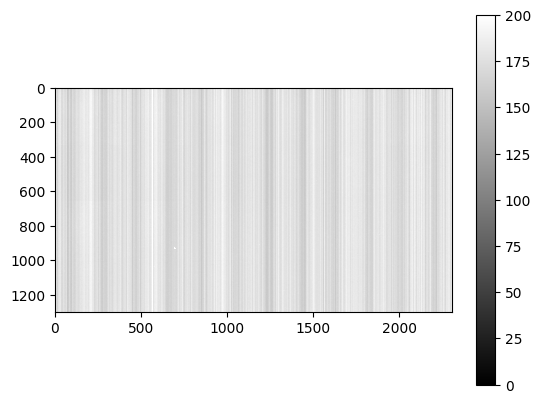

In [7]:
plt.imshow(background,cmap='gray',vmin=0,vmax=200)
plt.colorbar(orientation='vertical')

(1200.0, 0.0)

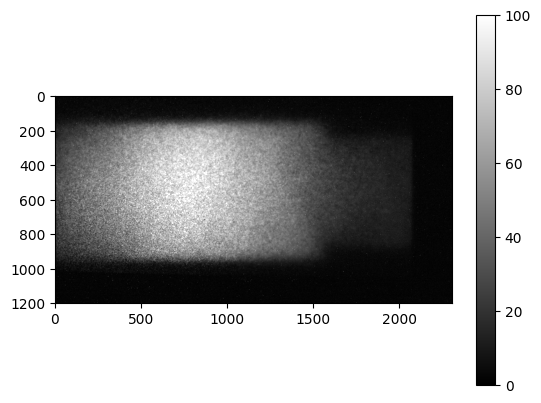

In [8]:
plt.imshow(camera_clean[1],cmap='gray',vmin=0,vmax=100)
plt.colorbar(orientation='vertical')
plt.ylim(1200,0)

In [9]:
#the counts outside the range depend on the temperature (so time in the experiment)

(1200.0, 1100.0)

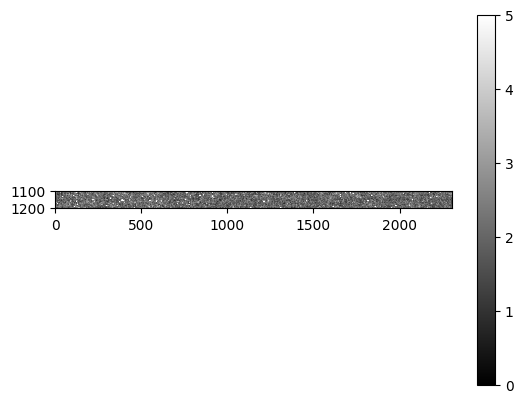

In [10]:
plt.imshow(camera_clean[4],cmap='gray',vmin=0,vmax=5)
plt.colorbar(orientation='vertical')
plt.ylim(1200,1100)

In [11]:
filename='datasets/galadriel_dataset_24_08_28_phys.h5'

In [12]:
df_input=pd.read_hdf(filename,'df_input')
df_camera=pd.read_hdf(filename,'df_camera')


#get the arrays and print them
print('Input DF')
print(df_input)

print('----')
print('Camera 1D')
print(df_camera)

Input DF
      shot number   order2   order3     order4  Laser Energy
0          108190  34900.0 -17000.0 -4600000.0      0.005440
1          108191  34900.0 -17000.0 -4600000.0      0.003417
2          108192  34900.0 -17000.0 -4600000.0      0.002906
3          108193  34900.0 -17000.0 -4600000.0      0.002910
4          108194  34900.0 -17000.0 -4600000.0      0.002744
...           ...      ...      ...        ...           ...
3068       111258  35400.0  28000.0 -3700000.0      0.003566
3069       111259  35400.0  28000.0 -3700000.0      0.003569
3070       111260  35400.0  28000.0 -3700000.0      0.003757
3071       111261  35400.0  28000.0 -3700000.0      0.003732
3072       111262  35400.0  28000.0 -3700000.0      0.003686

[3073 rows x 5 columns]
----
Camera 1D
         0        1        2        3        4        5        6        7     \
0     22.1425  21.1075  21.4750  21.6325  21.8700  22.7600  22.0525  22.0325   
1     24.5875  25.2550  24.8675  24.8900  25.3400  26.1425 

Text(0.5, 0, 'Pixels')

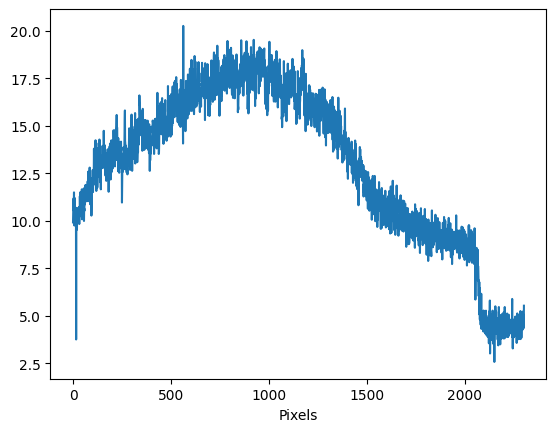

In [13]:
e_dist=df_camera.loc[200]
x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
MeV = 0.000002*x**2 - 0.0003 * x + .1265
#plt.plot(MeV,e_dist)
#plt.xlabel('Energy(MeV)')
#plt.show()

plt.plot(x,e_dist)
plt.xlabel('Pixels')

### Temperature analysis

In [14]:
cam_sum=df_camera.sum(axis=1)/len(df_camera.columns)

2.6363979282453515e-06 0.00769506667274072 22.64219354192436


Text(0, 0.5, 'Number of count per pixel')

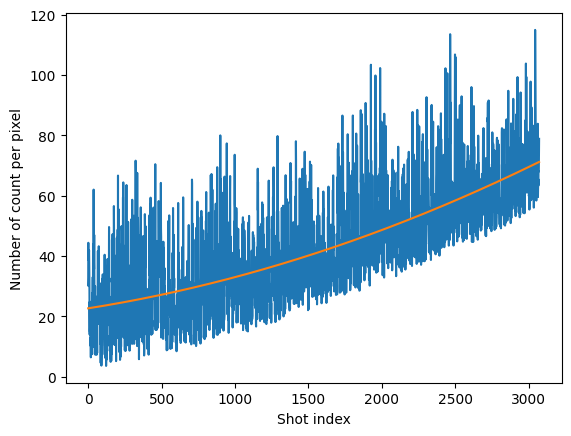

In [15]:
x=np.linspace(0,len(cam_sum)-1,len(cam_sum))
p1,p2,b = np.polyfit(x, cam_sum, 2)
print(p1,p2,b)
fitting=p1*x**2+p2*x+b

plt.plot(cam_sum)
plt.plot(fitting)
plt.xlabel('Shot index')
plt.ylabel('Number of count per pixel')

In [16]:
x=np.linspace(0,len(cam_sum)-1,len(cam_sum))
adj=p1*x**2+p2*x

In [17]:
cam_sum_adj=cam_sum-adj

Text(0, 0.5, 'Number of count per pixel')

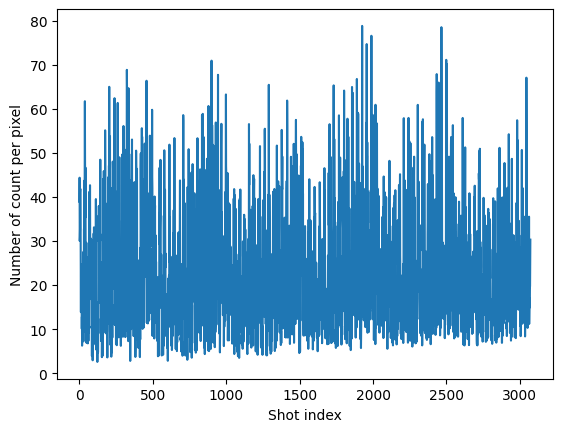

In [18]:
plt.plot(cam_sum_adj)
plt.xlabel('Shot index')
plt.ylabel('Number of count per pixel')

In [19]:
#function that takes the camera data and removes the temperautre effect
#1 calculate the total number of counts per shot
#2 fit a 2 order polynomial to this
#3 remove the trend from original data
def rmv_tmp_effect(df_camera):
    #1 calculate the average number of counts per shot
    cam_avg=df_camera.sum(axis=1)/len(df_camera.columns)
    
    #2 fit a 2 order polynomial to this
    x=np.linspace(0,len(cam_avg)-1,len(cam_avg))
    p1,p2,b = np.polyfit(x, cam_avg, 2)
    #print(p1,p2,b)

    adj=p1*x**2+p2*x #each shot needs to be adjusted by this value (x is shot index)
    #print(df_camera.sub(adj,axis=0))
    return df_camera.sub(adj,axis=0)

In [20]:
df_camera_no_tmp=rmv_tmp_effect(df_camera)

1.987973735125191e-22 5.781000228718746e-18 22.642193541924346


Text(0, 0.5, 'Number of count per pixel')

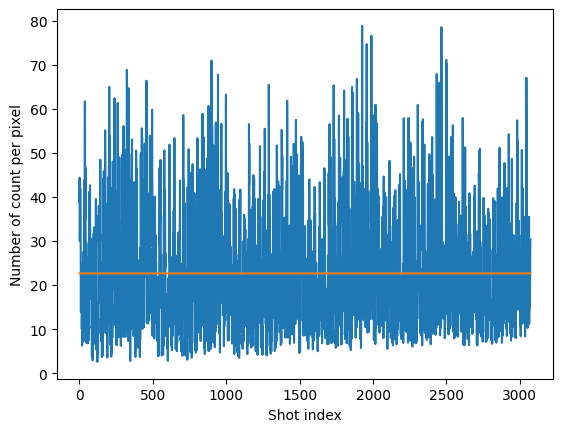

In [21]:
cam_sum=df_camera_no_tmp.sum(axis=1)/len(df_camera_no_tmp.columns)
x=np.linspace(0,len(cam_sum)-1,len(cam_sum))
p1,p2,b = np.polyfit(x, cam_sum, 2)
print(p1,p2,b)
fitting=p1*x**2+p2*x+b

plt.plot(cam_sum)
plt.plot(fitting)
plt.xlabel('Shot index')
plt.ylabel('Number of count per pixel')

## SMOOTH THE DATA and drop last values

In [22]:
#smooth the whole camera dataframe
df_camera_smooth=df_camera_no_tmp.apply(uniform_filter1d,axis=1,size=10,result_type='broadcast')

df_camera_smooth=df_camera_smooth.iloc[:,0:2000].copy()

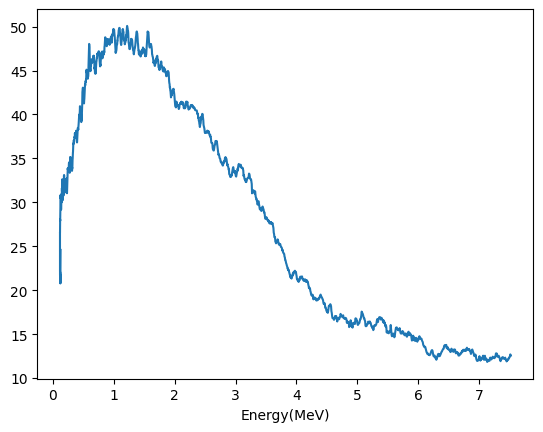

Text(0.5, 0, 'Pixels')

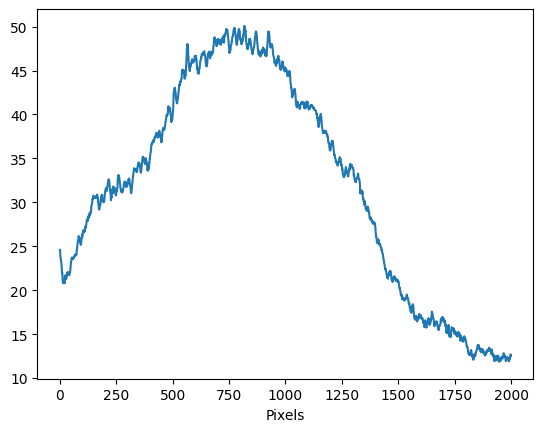

In [23]:
e_dist=df_camera_smooth.loc[2080]
x=np.linspace(0,len(df_camera_smooth.columns)-1,len(df_camera_smooth.columns))
MeV = 0.000002*x**2 - 0.0003 * x + .1265
plt.plot(MeV,e_dist)
plt.xlabel('Energy(MeV)')
plt.show()

plt.plot(x,e_dist)
plt.xlabel('Pixels')

## Remove the avg

In [24]:
lastpoints=300
df_camera_adjusted=rmv_mean(df_camera_smooth,lastpoints)

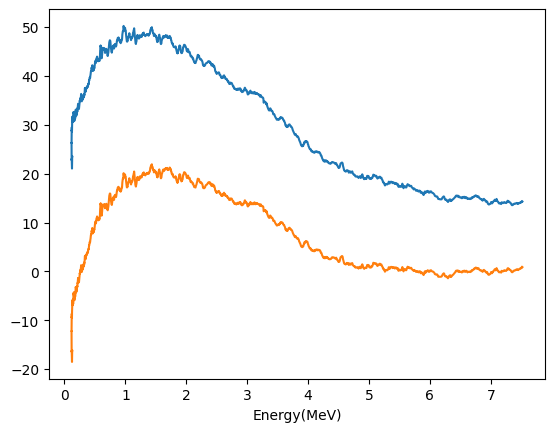

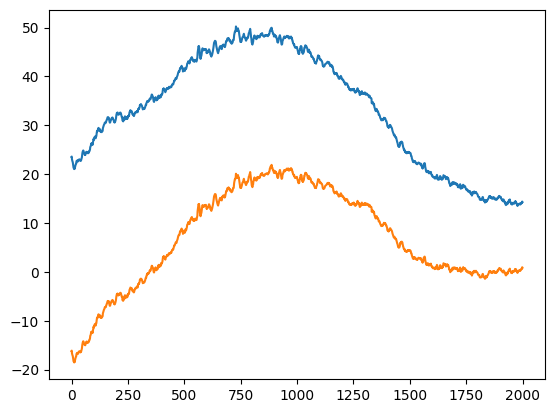

In [25]:
shot_index=1500
#fitting=coef.iloc[shot_index][0]*x+coef.iloc[shot_index][1]
e_dist=df_camera_smooth.loc[shot_index]
e_dist_adj=df_camera_adjusted.loc[shot_index]

MeV = 0.000002*x**2 - 0.0003 * x + .1265
plt.plot(MeV,e_dist)
plt.plot(MeV,e_dist_adj)
plt.xlabel('Energy(MeV)')
plt.show()

plt.plot(x,e_dist)
#plt.plot(fit[shot_index])
plt.plot(x,e_dist_adj)

### Look for the maximum

In [26]:
## Fit a curve to given (x,y) data
def fitting(x,y,p0):
    popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
    return popt

#define the curve to fit
def func(t,c0, c1,c2): 
    #return c0*np.log(c1)+c2*t
    #return c0*x**2+c1*x+c2
    return c0*np.exp(-((t-c1)**2)/(2*c2*c2))

#Look for max location using the fitting function (around the maximum value)
#Returns the 'pixel' location of the maximum
def find_max(e_dist):
    try:
        #x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #redefine a shorter range around the max
        e_zoom=e_dist[int(0.5*np.argmax(e_dist)):int(1.5*np.argmax(e_dist))]
        x_zoom=np.linspace(int(0.5*np.argmax(e_dist)),int(1.5*np.argmax(e_dist))-1,len(e_zoom))
        p0=[np.max(e_dist),500,1]#initial guess
        popt=fitting(x_zoom,e_zoom,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]
        
#Look for max location using the fitting function
#Returns the 'pixel' location of the maximum
def find_max_old(e_dist):
    try:
        #print(e_dist)
        x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #print(len(e_dist)-1,e_dist[1])
        p0=[np.max(e_dist),500,1]#initial guess
        popt=fitting(x,e_dist,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]

500.0
[6.136898208498604, 1, 1]
[5.374736   2.02671232 1.35336307]


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


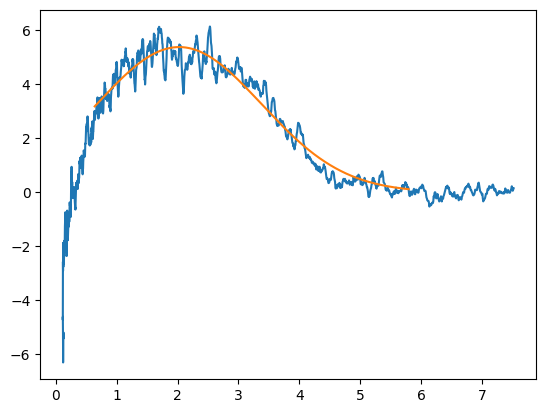

In [27]:
e_dist_adj=df_camera_adjusted.loc[200]
#x=np.linspace(0,len(df_camera_adjusted.columns)-1,len(df_camera_adjusted.columns))
x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))
x_ene=conv_energy(x)

e_zoom=e_dist_adj[int(0.5*np.argmax(e_dist_adj)):int(1.5*np.argmax(e_dist_adj))]
x_zoom=np.linspace(int(0.5*np.argmax(e_dist_adj)),int(1.5*np.argmax(e_dist_adj))-1,len(e_zoom))

print(find_max(e_dist_adj))

#fitting in the energy domain
#around the peak
p0=[np.max(e_dist_adj),1,1]#initial guess
print(p0)

x_ene_zoom=conv_energy(x_zoom)

popt=fitting(x_ene_zoom,e_zoom,p0)
print(popt)
y_fit=func(x_ene_zoom,popt[0],popt[1],popt[2])
plt.plot(x_ene,e_dist_adj)
plt.plot(x_ene_zoom,y_fit)
plt.show()

## Cut-off

In [28]:
#input a single shot (and the max location) and returns the position of the cut-off
def get_cutoff(df_camera_shot,maxpos):
    #The function look for the first zero value after the max value
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss
    
#input a single shot and returns the position of the cut-off
#This will be SLOWER than the other approach
def get_cutoff_2(df_camera_shot):
    #The function look for the first zero value after the max value
    #1:Look for the max value
    maxpos=find_max(df_camera_shot)
    #print(maxpos,len(df_camera_shot))
    #2)
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

## Area behind curve

In [29]:
def integr(e_dist):
    x=np.linspace(0,len(e_dist)-1,len(e_dist))
    #calculate the start(first positive) and end of integration(cut off)
    max_pos=find_max(e_dist)
    cutoff_pos=get_cutoff(e_dist,max_pos)  #end position
    start_pos=0
    for i in range(0,len(e_dist)):
        if (e_dist[i]>0):
            #print(i,e_dist[i])
            start_pos=i
            break
    e_dist_short=e_dist[start_pos:cutoff_pos]
    x_short=x[start_pos:cutoff_pos]
    
    #x=np.linspace(0,len(e_dist_short)-1,len(e_dist_short))
    x_ene=conv_energy(x_short)
    #return integrate.simpson(e_dist, x=x_ene)
    return integrate.trapezoid(e_dist_short, x=x_ene)

Integral: 73.74274815876673


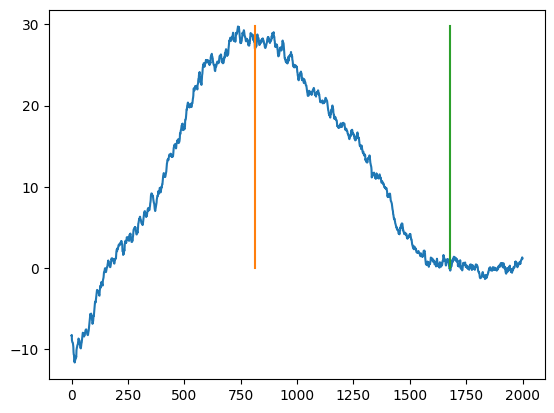

Text(0.5, 0, 'MeV')

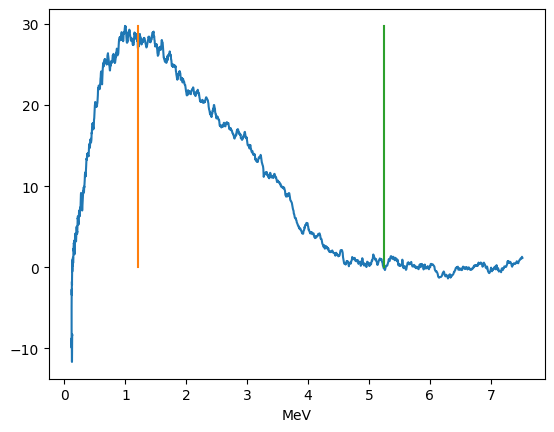

In [30]:
e_dist=df_camera_adjusted.loc[2012]

maxpos=find_max(e_dist)
cutoff_pos=get_cutoff(e_dist,maxpos)

#integrate
print('Integral:',integr(e_dist))

x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))

yaux=np.linspace(0,np.max(e_dist),10)
xaux_max=0*yaux+maxpos
xaux_cutoff=0*yaux+cutoff_pos
plt.plot(e_dist)
plt.plot(xaux_max,yaux)
plt.plot(xaux_cutoff,yaux)
plt.show()

#in energy
x_ene=conv_energy(x)
x_max_ene=conv_energy(xaux_max)
x_cutoff_ene=conv_energy(xaux_cutoff)
plt.plot(x_ene,e_dist)
plt.plot(x_max_ene,yaux)
plt.plot(x_cutoff_ene,yaux)
plt.xlabel('MeV')

## Construct the dataframe with metrics

In [31]:
df_metrics=pd.DataFrame()
df_metrics['Max E']=df_camera_adjusted.apply(find_max,axis=1)
#convert to Energy
df_metrics['Max E']=df_metrics['Max E'].apply(conv_energy)

/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in t

In [32]:
#calculate hte cutoff energy
df_metrics['Cutoff E']=df_camera_adjusted.apply(get_cutoff_2,axis=1)
#convert to Energy
df_metrics['Cutoff E']=df_metrics['Cutoff E'].apply(conv_energy)

/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


In [33]:
#calculate the integral
df_metrics['Integr']=df_camera_adjusted.apply(integr,axis=1)

/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8185/2225689608.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


In [34]:
df_metrics['Integr norm']=df_metrics['Integr'].div(df_input['Laser Energy'])

In [35]:
df_metrics[['Integr','Integr norm']]

,Integr,Integr norm
0,102.933000,18921.486432
1,142.140938,41603.812312
2,80.946907,27853.089962
3,83.457315,28674.685236
4,85.907048,31307.600384
...,...,...
3068,31.482231,8828.780794
3069,23.212834,6504.074338
3070,0.019728,5.251064
3071,35.430683,9493.698377


Text(0, 0.5, 'Num. shots')

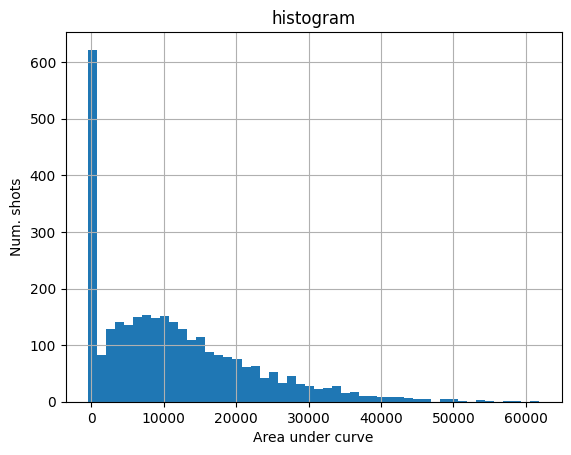

In [36]:
df_metrics['Integr norm'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Area under curve')
plt.ylabel('Num. shots')

Text(0, 0.5, 'Num. shots')

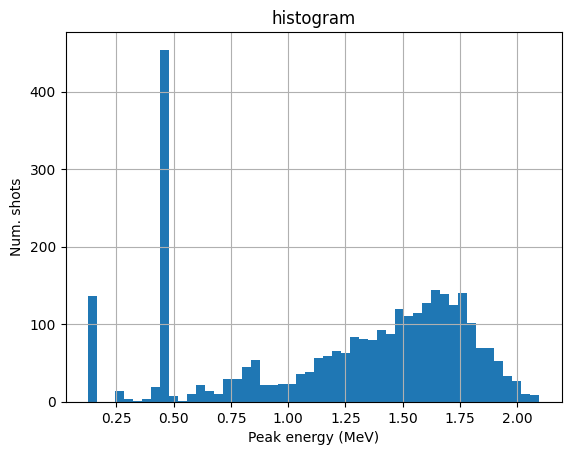

In [37]:
df_metrics['Max E'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Peak energy (MeV)')
plt.ylabel('Num. shots')

## Drop te shots with wrong max E (are the same with wrong integral)

In [38]:
df_metrics_reduced=df_metrics[df_metrics['Max E']>0.5]

good_shots_list=df_metrics_reduced.index.values
#print(good_shots_list)
#remove those wrong points fromt he input list
df_input_reduced=df_input.iloc[good_shots_list]

#reset the indexes
df_metrics_reduced.reset_index(inplace=True,drop=True)
df_input_reduced.reset_index(inplace=True,drop=True)

Text(0, 0.5, 'Num. shots')

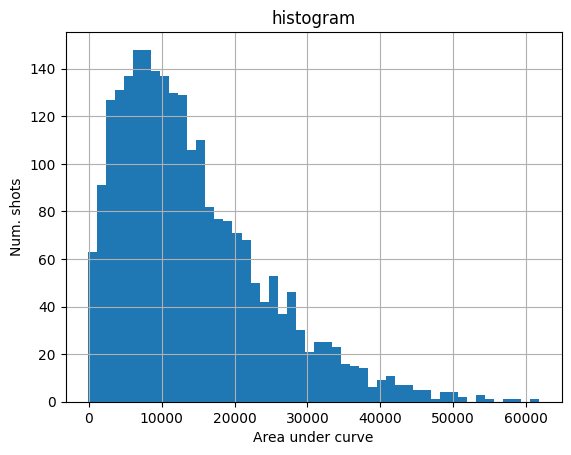

In [39]:
df_metrics_reduced['Integr norm'].hist(bins=50)
plt.title('histogram')
plt.xlabel('Area under curve')
plt.ylabel('Num. shots')

## Average shots

In [40]:
#Average shots with same input param
#NOTE: the 'integ' values are the normalized
def shot_average(df_input,df_metrics):
    emax_list=[]
    ecut_list=[]
    integ_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    emax_mean=[]
    emax_std=[]
    ecut_mean=[]
    ecut_std=[]
    integ_mean=[]
    integ_std=[]
    integ_mean=[]
    integ_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            emax_list.append(df_metrics['Max E'].iloc[index])
            ecut_list.append(df_metrics['Cutoff E'].iloc[index])
            integ_list.append(df_metrics['Integr norm'].iloc[index])
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                emax_list.append(df_metrics['Max E'].iloc[index])
                ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the calc
                emax_mean.append(np.mean(emax_list))
                emax_std.append(np.std(emax_list))
                ecut_mean.append(np.mean(ecut_list))
                ecut_std.append(np.std(ecut_list))
                integ_mean.append(np.mean(integ_list))
                integ_std.append(np.std(integ_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                #start the new batch
                emax_list=[df_metrics['Max E'].iloc[index]]
                ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_metrics_avg=pd.DataFrame()
    df_metrics_avg['order2']=o2_list
    df_metrics_avg['order3']=o3_list
    df_metrics_avg['order4']=o4_list
    df_metrics_avg['Emax mean']=emax_mean
    df_metrics_avg['Emax std']=emax_std
    df_metrics_avg['Ecut mean']=ecut_mean
    df_metrics_avg['Ecut std']=ecut_std
    df_metrics_avg['Integr mean']=integ_mean
    df_metrics_avg['Integr std']=integ_std
    return df_metrics_avg

In [41]:
df_metrics_avg=shot_average(df_input_reduced,df_metrics_reduced)

In [42]:
df_metrics_avg

,order2,order3,order4,Emax mean,Emax std,Ecut mean,Ecut std,Integr mean,Integr std
0,34900.0,-17000.0,-4600000.0,1.619803,0.147905,5.661467,0.079805,31393.157295,5782.500323
1,34900.0,-17000.0,-4300000.0,1.312829,0.172187,5.476666,0.149341,21209.830205,7846.683875
2,34900.0,-17000.0,-4000000.0,1.151174,0.149243,5.476425,0.186318,17308.857994,6925.524027
3,34900.0,-17000.0,-3700000.0,1.383602,0.155743,5.512110,0.162323,21199.193456,9712.667883
4,34900.0,-14000.0,-4600000.0,1.571909,0.187845,5.595426,0.071765,39787.362761,11375.661403
...,...,...,...,...,...,...,...,...,...
378,35400.0,25000.0,-4000000.0,1.749521,0.188579,4.261263,0.300153,8508.515278,3448.910495
379,35400.0,25000.0,-3700000.0,1.419941,0.293627,3.988185,0.623316,9424.851387,5875.029784
380,35400.0,28000.0,-4600000.0,1.724401,0.178590,4.900776,0.533102,15325.454063,8053.379725
381,35400.0,28000.0,-4300000.0,1.832897,0.139860,4.451143,0.371090,7674.404644,2569.419098


In [43]:
print(df_metrics_avg[df_metrics_avg['Integr mean']>30000])

      order2   order3     order4  Emax mean  Emax std  Ecut mean  Ecut std  \
0    34900.0 -17000.0 -4600000.0   1.619803  0.147905   5.661467  0.079805   
4    34900.0 -14000.0 -4600000.0   1.571909  0.187845   5.595426  0.071765   
68   35000.0 -14000.0 -4600000.0   1.773465  0.137205   5.562713  0.075759   
213  35200.0  -2000.0 -4300000.0   1.293985  0.097178   5.356486  0.465320   
268  35300.0  -8000.0 -4600000.0   1.577120  0.196276   5.214345  0.382377   
272  35300.0  -5000.0 -4600000.0   1.639598  0.117444   5.233647  0.357574   
276  35300.0  -2000.0 -4600000.0   1.453054  0.160786   4.918541  0.634854   
340  35400.0  -2000.0 -4600000.0   1.461462  0.215234   5.024570  0.380566   

      Integr mean    Integr std  
0    31393.157295   5782.500323  
4    39787.362761  11375.661403  
68   31528.780770   9433.392682  
213  36925.506810  16963.094335  
268  32005.438407   8354.784580  
272  31273.362843   8271.045419  
276  31803.339388  17329.919853  
340  39290.189601  13347.

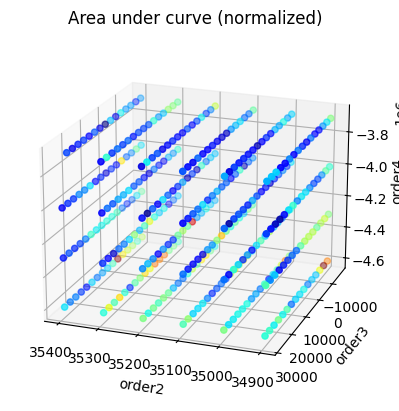

In [47]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_metrics_avg['order2'], df_metrics_avg['order3'], df_metrics_avg['order4'],c=df_metrics_avg['Integr mean'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=110)
plt.title('Area under curve (normalized)')
plt.show()